## Isolating weather Stations in wine areas

In [1]:
import pandas as pd
import os
import requests
import openpyxl
import matplotlib.pyplot as plt

from dotenv import load_dotenv

## Clean and pivot climate data tables to one record for each station / year

In [2]:
# Load the Weather Data
file_path = 'Resources/weather_all_country_codes3.csv'
df = pd.read_csv(file_path)

# Pivot the Weather DataFrame
pivoted_df = df.pivot_table(index=['station', 'date'], columns='datatype', values='value').reset_index()


# Load the Station Codes Data
column_names = ['station_id', 'latitude', 'longitude', 'elevation', 'location']
colspecs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, None)]
file_path_txt = 'Resources/stationcodes.txt'
df_station_codes = pd.read_fwf(file_path_txt, colspecs=colspecs, header=None, names=column_names)


# Rename Columns for Merging
df_station_codes.rename(columns={'station_id': 'station'}, inplace=True)

# Clean Column Names
pivoted_df.columns = pivoted_df.columns.str.strip()
df_station_codes.columns = df_station_codes.columns.str.strip()

# Remove the 'GHCND:' prefix from the 'station' column in both DataFrames
pivoted_df['station'] = pivoted_df['station'].str.replace('GHCND:', '')
df_station_codes['station'] = df_station_codes['station'].str.replace('GHCND:', '')


# Update the 'country' values
pivoted_df['country'] = pivoted_df['station'].str[:2]

# Merge the DataFrames to add Lat, Long to weather data
merged_df = pd.merge(pivoted_df, df_station_codes, on='station', how='left')

# Export the merged DataFrame to a CSV file
output_file_path = 'Resources/merged_weather_data.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"Merged DataFrame exported to {output_file_path}")




Merged DataFrame exported to Resources/merged_weather_data.csv


##Begin Spatial analysis of wine regions to weather stations

                      name     latitude     longitude  \
0           AOC Haut-M̩doc  45.22208291  -0.898633072   
1              AOC Ajaccio  41.88872288   8.804930084   
2  DOC Costa d&apos;Amalfi   40.6214488   14.57208446   
3            AOC Hermitage  45.07462896   4.837683076   
4               AOC Alsace  48.66041665   7.659245758   

                    geometry  
0  POINT (-0.89863 45.22208)  
1   POINT (8.80493 41.88872)  
2  POINT (14.57208 40.62145)  
3   POINT (4.83768 45.07463)  
4   POINT (7.65925 48.66042)  


<Axes: >

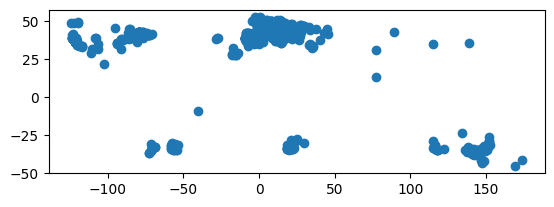

In [3]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Load the shapefile
shapefile_path = 'Resources/Shapefiles/GlobalVineyards.shp'
gdf_shape = gpd.read_file(shapefile_path)

# Ensure the shapefile uses the same coordinate system as the weather data
gdf_shape = gdf_shape.to_crs(epsg=4326)

# Display the first few rows of the GeoDataFrame
print(gdf_shape.head())

# Plot the shapefile
gdf_shape.plot()


In [4]:

# Check for stations that did not get lat and long coordinates
stations_df = merged_df.dropna(subset=['latitude', 'longitude'])  # Drop rows with missing coordinates

# Create a GeoDataFrame from the weather station DataFrame
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
gdf_stations = gpd.GeoDataFrame(stations_df, geometry=geometry)

# Ensure the GeoDataFrame uses the same coordinate system
gdf_stations.crs = "EPSG:4326"


In [5]:
# Re-project both GeoDataFrames to a projected CRS suitable for distance calculations
projected_crs = "EPSG:3395"  # World Mercator projection
gdf_shape = gdf_shape.to_crs(projected_crs)
gdf_stations = gdf_stations.to_crs(projected_crs)

# Convert distance to meters (100 miles is approximately 160934 meters)
buffer_distance = 160934  # 100 miles in meters

# Create a buffer around the shapefile geometries
shape_buffer = gdf_shape.geometry.buffer(buffer_distance)

# Combine all buffered shapes into a single geometry
combined_shape_buffer = unary_union(shape_buffer)

# Find weather stations within the buffer
stations_within_buffer = gdf_stations[gdf_stations.geometry.within(combined_shape_buffer)]

# Display the results
print(stations_within_buffer)

# Optionally, save the results to a new CSV file
output_file_path = 'Resources/stations_within_100_miles.csv'
stations_within_buffer.to_csv(output_file_path, index=False)
print(f"Stations within 100 miles exported to {output_file_path}")

# Re-project back to geographic CRS for plotting
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)
shape_buffer_geo = gpd.GeoSeries([combined_shape_buffer], crs=projected_crs).to_crs(epsg=4326)

# Display the results
stations_within_buffer


           station                 date  DP10  DP1X  DT32   DX70  DX90  EMNT  \
16     AG000060390  1995-01-01T00:00:00  40.0   4.0   3.0  239.0  27.0  31.0   
17     AG000060390  1996-01-01T00:00:00  59.0   6.0   2.0  228.0  21.0  29.0   
18     AG000060390  1997-01-01T00:00:00  44.0   5.0   0.0  231.0  20.0  33.0   
19     AG000060390  1998-01-01T00:00:00  47.0   6.0   4.0  220.0  30.0  30.0   
20     AG000060390  2004-01-01T00:00:00  51.0   8.0   NaN    NaN   NaN   NaN   
...            ...                  ...   ...   ...   ...    ...   ...   ...   
30213  UYM00086580  2016-01-01T00:00:00  58.0  13.0   NaN    NaN   NaN   NaN   
30214  UYM00086580  2017-01-01T00:00:00  62.0  18.0   NaN    NaN   NaN   NaN   
30215  UYM00086580  2018-01-01T00:00:00  68.0  15.0   NaN    NaN   NaN   NaN   
30216  UYM00086580  2019-01-01T00:00:00  62.0  16.0   NaN    NaN   NaN   NaN   
30217  UYM00086580  2022-01-01T00:00:00  49.0   7.0   NaN    NaN   NaN   NaN   

       EMXP   EMXT  ...  MXPN   PRCP  T

,station,date,DP10,DP1X,DT32,DX70,DX90,EMNT,EMXP,EMXT,...,MXPN,PRCP,TAVG,TMAX,country,latitude,longitude,elevation,location,geometry
16,AG000060390,1995-01-01T00:00:00,40.0,4.0,3.0,239.0,27.0,31.0,1.60,105.0,...,NaN,21.72,64.5,75.5,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
17,AG000060390,1996-01-01T00:00:00,59.0,6.0,2.0,228.0,21.0,29.0,2.56,113.0,...,NaN,31.57,63.6,73.5,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
18,AG000060390,1997-01-01T00:00:00,44.0,5.0,0.0,231.0,20.0,33.0,2.08,101.0,...,NaN,21.52,65.0,75.4,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
19,AG000060390,1998-01-01T00:00:00,47.0,6.0,4.0,220.0,30.0,30.0,1.92,104.0,...,NaN,23.99,63.7,74.8,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
20,AG000060390,2004-01-01T00:00:00,51.0,8.0,NaN,NaN,NaN,NaN,1.85,NaN,...,NaN,25.31,NaN,NaN,AG,36.7167,3.250,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30213,UYM00086580,2016-01-01T00:00:00,58.0,13.0,NaN,NaN,NaN,NaN,3.76,NaN,...,NaN,44.57,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)
30214,UYM00086580,2017-01-01T00:00:00,62.0,18.0,NaN,NaN,NaN,NaN,6.44,NaN,...,NaN,57.66,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)
30215,UYM00086580,2018-01-01T00:00:00,68.0,15.0,NaN,NaN,NaN,NaN,7.01,NaN,...,NaN,58.26,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)
30216,UYM00086580,2019-01-01T00:00:00,62.0,16.0,NaN,NaN,NaN,NaN,3.07,NaN,...,NaN,47.50,NaN,NaN,UY,-34.8380,-56.031,32.0,CARRASCO INTL 86580,POINT (-56.03100 -34.83800)


# Plot stations within wine regions

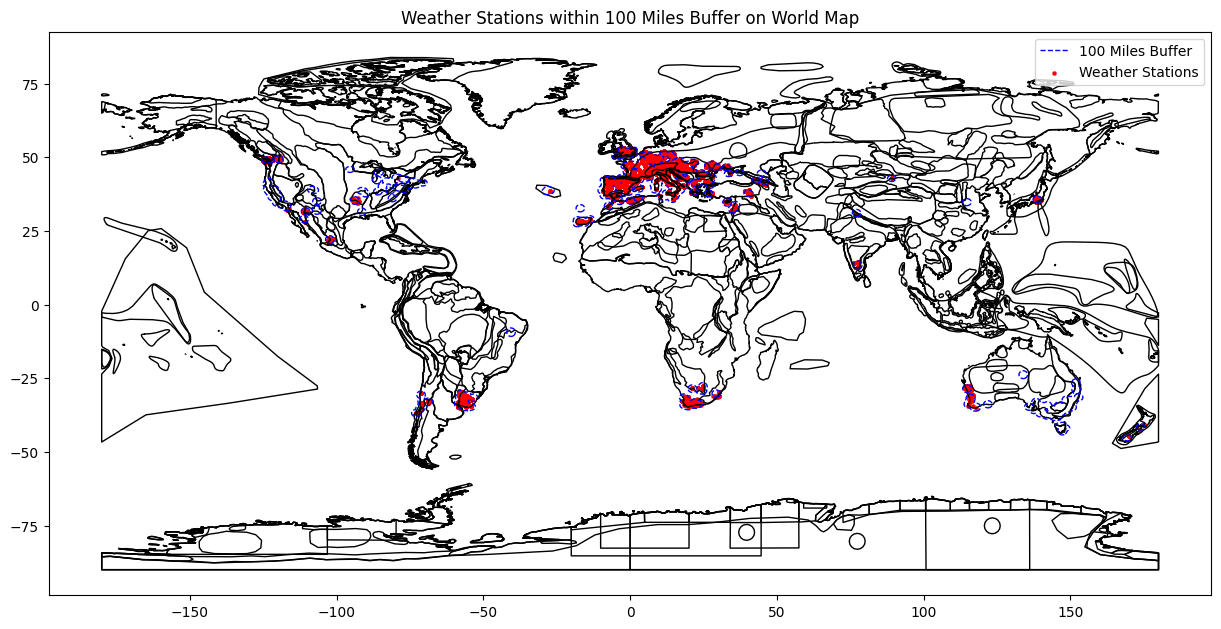

In [6]:
# Load a world map
# Load the world map from Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/ne_50m_geography_regions_polys.shp'
world = gpd.read_file(world_shapefile_path)

# Plot the world map, buffer, and stations within the buffer
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1, color='black')
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='100 Miles Buffer')
stations_within_buffer.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

plt.title('Weather Stations within 100 Miles Buffer on World Map')
plt.legend()
plt.show()


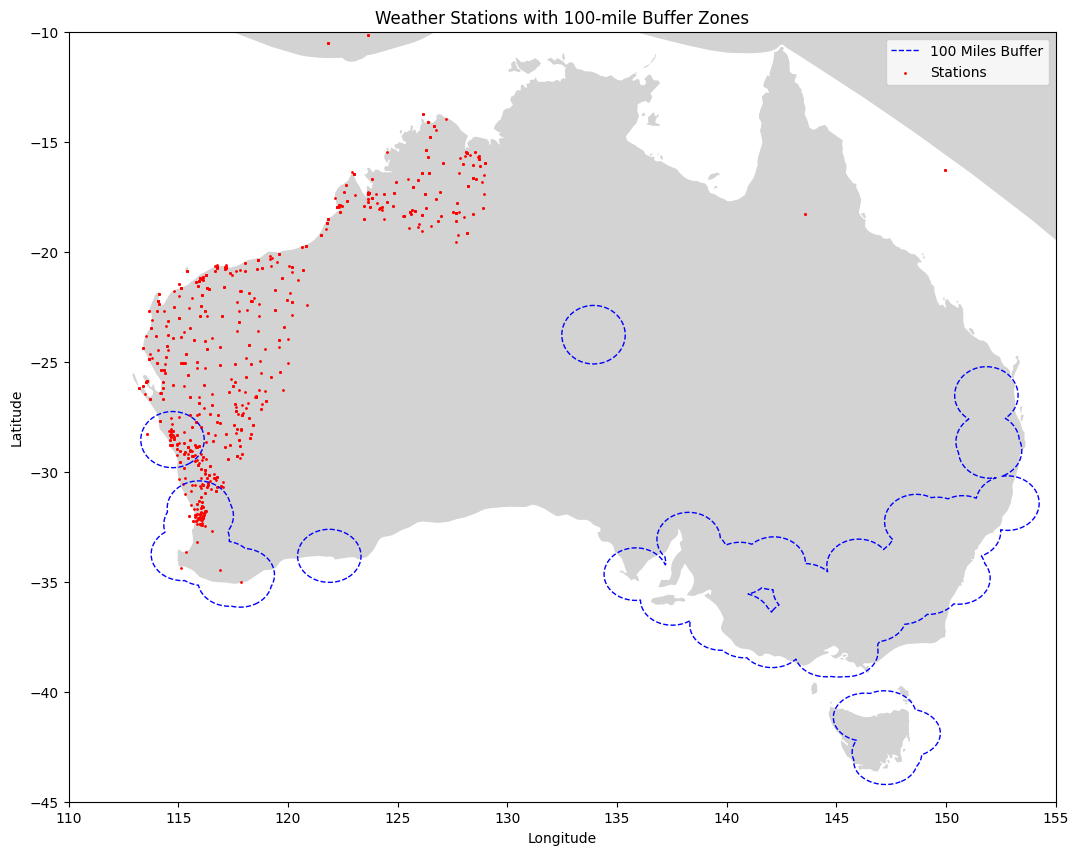

In [7]:
#What is the deal with Australia weather stations?

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_df['longitude'], merged_df['latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Set the CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

world_shapefile_path = 'Resources/Shapefiles/ne_50m_geography_regions_polys.shp'
world = gpd.read_file(world_shapefile_path)

# Plot the world map, buffer, and stations within the buffer
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray')
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='100 Miles Buffer')

# Plot the stations
gdf.plot(ax=ax, color='red', markersize=1, label='Stations')


# Set the limits to zoom in on Australia
ax.set_xlim(110, 155)
ax.set_ylim(-45, -10)

# Add legend and title
plt.legend()
plt.title('Weather Stations with 100-mile Buffer Zones')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
#Double checking my new start file matches up with original start file

import pandas as pd

# Load the weather_all_country_codes3.csv file
weather_file_path = 'Resources/weather_all_country_codes3.csv'
weather_df = pd.read_csv(weather_file_path)

# Load the merged_weather_data.csv file
merged_file_path = 'Resources/merged_weather_data.csv'
merged_df = pd.read_csv(merged_file_path)

# Ensure the station identifiers are consistent (e.g., remove 'GHCND:' prefix if necessary)
weather_df['station'] = weather_df['station'].str.replace('GHCND:', '')
merged_df['station'] = merged_df['station'].str.replace('GHCND:', '')

# Calculate the number of unique station IDs in each file
unique_stations_weather = weather_df['station'].nunique()
unique_stations_merged = merged_df['station'].nunique()

print(f"Number of unique stations in weather_all_country_codes3.csv: {unique_stations_weather}")
print(f"Number of unique stations in merged_weather_data.csv: {unique_stations_merged}")


Number of unique stations in weather_all_country_codes3.csv: 6303
Number of unique stations in merged_weather_data.csv: 6303


In [9]:
#Checking to see if eliminated any countries that should not have been by using the regions Then added back in country data

import pandas as pd

# Load the merged weather station file
merged_file_path = 'Resources/merged_weather_data.csv'
merged_df = pd.read_csv(merged_file_path)

# Load the stations_within_buffer file
stations_within_buffer_file_path = 'Resources/stations_within_100_miles.csv'  # Update this path
stations_within_buffer = pd.read_csv(stations_within_buffer_file_path)

# Load the country codes file
country_codes_file_path = 'Resources/ghcnd-countries.csv'  # Update this path
country_codes_df = pd.read_csv(country_codes_file_path)

# Load the wine data file
wine_data_file_path = 'Resources/Wine_data_all_update_codes.csv'
wine_df = pd.read_csv(wine_data_file_path)

# Extract unique country codes
unique_country_codes_merged = set(merged_df['country'].unique())
unique_country_codes_buffer = set(stations_within_buffer['country'].unique())

# Find country codes in merged_df but not in stations_within_buffer
missing_country_codes = unique_country_codes_merged - unique_country_codes_buffer

# Create a dictionary to map country codes to country names
country_code_to_name = dict(zip(country_codes_df['Code'], country_codes_df['Country']))

# Get the country names for the missing country codes
missing_countries = {code: country_code_to_name.get(code, 'Unknown') for code in missing_country_codes}

# Display the results
missing_countries_df = pd.DataFrame(list(missing_countries.items()), columns=['Country Code', 'Country Name'])
print("Country codes and names in merged_df but not in stations_within_buffer:")
print(missing_countries_df)

# Check if the missing countries exist in the wine data file
missing_countries_in_wine = missing_countries_df[missing_countries_df['Country Code'].isin(wine_df['country'].unique())]

# Filter the merged weather data for the missing countries that are in the wine data file
additional_weather_data = merged_df[merged_df['country'].isin(missing_countries_in_wine['Country Code'])]

# Add the additional weather data back to the buffer data
updated_buffer_data = pd.concat([stations_within_buffer, additional_weather_data])

# Save the updated buffer data
updated_buffer_file_path = 'Resources/updated_stations_within_100_miles.csv'  # Update this path
updated_buffer_data.to_csv(updated_buffer_file_path, index=False)

print(f"Updated buffer data saved to {updated_buffer_file_path}")



Country codes and names in merged_df but not in stations_within_buffer:
    Country Code                    Country Name
0             MA                      Madagascar
1             PA                        Paraguay
2             JQ  Johnston Atoll [United States]
3             PK                        Pakistan
4             BG                      Bangladesh
..           ...                             ...
99            KE                           Kenya
100           BD        Bermuda [United Kingdom]
101           AE            United Arab Emirates
102           FP                French Polynesia
103           KG                      Kyrgyzstan

[104 rows x 2 columns]
Updated buffer data saved to Resources/updated_stations_within_100_miles.csv


##Clean up station data to have only an averaged data value for each country by year. 

In [10]:
import pandas as pd

# Load the CSV file
file_path = 'Resources/updated_stations_within_100_miles.csv'
data = pd.read_csv(file_path)

# Specify the columns to average and calculate standard deviation
columns_to_average = ['DP10', 'DP1X', 'DT32', 'DX70', 'DX90', 'EMNT', 'EMXP', 'EMXT', 'HTDD', 'MNPN', 'MXPN', 'PRCP', 'TAVG', 'TMAX']

# Group by 'country' and 'date', then calculate the mean and standard deviation
grouped_data = data.groupby(['country', 'date'])[columns_to_average].agg(['mean', 'std']).reset_index()

# Flatten the column names
grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

# Save the cleaned and grouped data to a new CSV file if needed
output_path = 'Resources/averages_updated_100_mile_stations.csv'
grouped_data.to_csv(output_path, index=False)

# Display the first few rows of the cleaned and grouped data
print(grouped_data.head())


  country                 date  DP10_mean  DP10_std  DP1X_mean  DP1X_std  \
0      AE  1996-01-01T00:00:00        NaN       NaN        NaN       NaN   
1      AE  2004-01-01T00:00:00        4.0       NaN        0.0       NaN   
2      AE  2006-01-01T00:00:00        7.0       NaN        1.0       NaN   
3      AE  2008-01-01T00:00:00        NaN       NaN        NaN       NaN   
4      AE  2009-01-01T00:00:00        NaN       NaN        NaN       NaN   

   DT32_mean  DT32_std  DX70_mean  DX70_std  ...  MNPN_mean  MNPN_std  \
0        NaN       NaN      339.0       NaN  ...        NaN       NaN   
1        NaN       NaN        NaN       NaN  ...        NaN       NaN   
2        NaN       NaN      335.0       NaN  ...        NaN       NaN   
3        NaN       NaN      330.0       NaN  ...        NaN       NaN   
4        NaN       NaN      329.0       NaN  ...        NaN       NaN   

   MXPN_mean  MXPN_std  PRCP_mean  PRCP_std  TAVG_mean  TAVG_std  TMAX_mean  \
0        NaN       NaN   

In [11]:

# Load the newly saved wine data file
wine_data = pd.read_csv('Resources/Wine_data_all_update_codes.csv')

# Convert date columns to datetime to ensure proper merging
grouped_data['date'] = pd.to_datetime(grouped_data['date'])
wine_data['Year'] = pd.to_datetime(wine_data['Year'], format='%Y')

# Merge the dataframes on 'country' (country_code) and 'date' (Year)
merged_data = pd.merge(
    wine_data, 
    grouped_data, 
    left_on=['country', 'Year'], 
    right_on=['country', 'date'], 
    how='inner'
)

# Drop the duplicate columns used for merging
merged_data = merged_data.drop(columns=['date'])

# Save the merged data to a new CSV file
merged_output_path = 'Resources/merged_wine_weather_for_regions_data.csv'
merged_data.to_csv(merged_output_path, index=False)

# Display the first few rows of the merged data
merged_data.head()


,Year,country,Gallons,DP10_mean,DP10_std,DP1X_mean,DP1X_std,DT32_mean,DT32_std,DX70_mean,...,MNPN_mean,MNPN_std,MXPN_mean,MXPN_std,PRCP_mean,PRCP_std,TAVG_mean,TAVG_std,TMAX_mean,TMAX_std
0,1995-01-01,AL,4464506.8,97.0,NaN,29.0,NaN,NaN,NaN,160.0,...,NaN,NaN,NaN,NaN,90.82,NaN,NaN,NaN,66.9,NaN
1,1996-01-01,AL,7740239.6,101.0,NaN,30.0,NaN,NaN,NaN,173.0,...,NaN,NaN,NaN,NaN,92.59,NaN,NaN,NaN,68.7,NaN
2,1997-01-01,AL,4438089.6,70.0,NaN,16.0,NaN,NaN,NaN,161.0,...,NaN,NaN,NaN,NaN,57.74,NaN,NaN,NaN,68.7,NaN
3,1999-01-01,AL,3354984.4,91.0,NaN,24.0,NaN,NaN,NaN,188.0,...,NaN,NaN,NaN,NaN,72.34,NaN,NaN,NaN,71.3,NaN
4,2000-01-01,AL,1954872.8,70.0,NaN,23.0,NaN,NaN,NaN,185.0,...,NaN,NaN,NaN,NaN,69.22,NaN,NaN,NaN,71.5,NaN


In [12]:

import pandas as pd


# Load the Wine data
wine_data_org_data = pd.read_csv('Resources/Wine_data_all_update_codes.csv')

# Load the CSV file
region_wine_weather_data = pd.read_csv('Resources/merged_wine_weather_for_regions_data.csv')

# Convert the 'Year' in CSV data to a format similar to the 'Year' in Excel data
region_wine_weather_data['Year'] = pd.to_datetime(region_wine_weather_data['Year']).dt.year

# Merge the two datasets to find differences
wine_key = wine_data_org_data[['country', 'Year']]
weather_key = region_wine_weather_data[['country', 'Year']]

# Find rows in wine data that are not in weather region data
missing_in_weather = wine_key.merge(weather_key, on=['country', 'Year'], how='left', indicator=True)
missing_in_weather = missing_in_weather[missing_in_weather['_merge'] == 'left_only'].drop(columns=['_merge'])

missing_in_weather_rows = wine_data_org_data[wine_data_org_data[['country', 'Year']].apply(tuple, axis=1).isin(missing_in_weather.apply(tuple, axis=1))]

# Calculate the number of rows removed
rows_removed = len(missing_in_weather_rows)

# Summarize the missing data by country
summary_by_country = missing_in_weather_rows.groupby('country').size().reset_index(name='Count')

print(f"Number of rows removed: {rows_removed}")
print("Summary by country:")
print(summary_by_country)


Number of rows removed: 3837
Summary by country:
    country  Count
0        AA     28
1        AC     28
2        AE     17
3        AF     28
4        AG      6
..      ...    ...
196      WS     28
197      WZ     28
198      YM     28
199      ZA     28
200      ZI     28

[201 rows x 2 columns]
